In [69]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

import pickle
import bisect

plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# hyper parameter
BATCH_SIZE = 1000

In [3]:
# define paths
ll_model_path = Path("../data/models/CIFAR10_PowerLaw")
model_path = ll_model_path
figure_path = Path("../data/figures/NORAConf23Poster")

# define file names
khmodel_file = Path("KHModel.pty")
khmodel_scheduled_file = Path("KHModel_scheduled.pty")
bpmodel_file = Path("BPModel.pty")
bpmodel_scheduled_file = Path("BPModel_scheduled.pty")

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
# define colormap for all the poster plots
cmap = {
    "kh": "#762a83",
    "hybrid": "#f8a953",
    "bp": "#1b7837",#"#106151",
}

### load all models

In [6]:
khmodel_state = torch.load(model_path / khmodel_file)
khmodel = LocalLearning.KHModel(khmodel_state["fkhl3-state"])
khmodel.load_state_dict(khmodel_state["model_state_dict"])
khmodel.to(device)
khmodel.eval()

KHModel(
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu_h): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=True)
  (softMax): Softmax(dim=-1)
)

In [7]:
khmodel_scheduled_state = torch.load(model_path / khmodel_scheduled_file)
khmodel_scheduled = LocalLearning.KHModel(khmodel_scheduled_state["fkhl3-state"])
khmodel_scheduled.load_state_dict(khmodel_scheduled_state["model_state_dict"])
khmodel.to(device)
khmodel_scheduled.eval()

KHModel(
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu_h): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=True)
  (softMax): Softmax(dim=-1)
)

In [8]:
bpmodel_state = torch.load(model_path / bpmodel_file)
bpmodel = LocalLearning.SHLP(params=bpmodel_state["params"])
bpmodel.load_state_dict(bpmodel_state["model_state_dict"])
bpmodel.to(device)
bpmodel.eval()

SHLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=True)
)

In [9]:
bpmodel_scheduled_state = torch.load(model_path / bpmodel_scheduled_file)
bpmodel_scheduled = LocalLearning.SHLP(params=bpmodel_scheduled_state["params"])
bpmodel_scheduled.load_state_dict(bpmodel_scheduled_state["model_state_dict"])
bpmodel_scheduled.to(device)
bpmodel_scheduled.eval()

SHLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=True)
)

# Model Performance Comparison

In [10]:
lh_khmodel_cpu = np.array(
    [a.cpu().detach().numpy() for a in khmodel_state["loss_history"]]
)
ah_khmodel_cpu = np.array(
    [a.cpu().detach().numpy() for a in khmodel_state["accuracy_history"]]
)
lh_khmodel_scheduled_cpu = np.array(
    [a.cpu().detach().numpy() for a in khmodel_scheduled_state["loss_history"]]
)
ah_khmodel_scheduled_cpu = np.array(
    [a.cpu().detach().numpy() for a in khmodel_scheduled_state["accuracy_history"]]
)
lh_bpmodel_cpu = np.array(
    [a.cpu().detach().numpy() for a in bpmodel_state["loss_history"]]
)
ah_bpmodel_cpu = np.array(
    [a.cpu().detach().numpy() for a in bpmodel_state["accuracy_history"]]
)
lh_bpmodel_scheduled_cpu = np.array(
    [a.cpu().detach().numpy() for a in bpmodel_scheduled_state["loss_history"]]
)
ah_bpmodel_scheduled_cpu = np.array(
    [a.cpu().detach().numpy() for a in bpmodel_scheduled_state["accuracy_history"]]
)

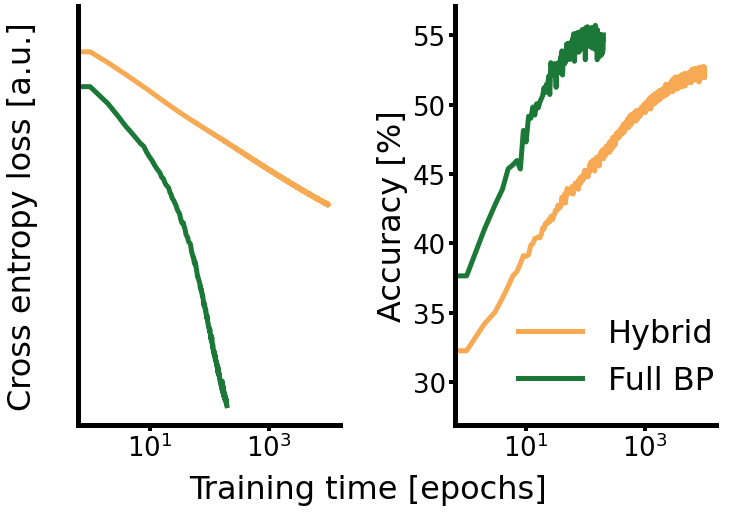

In [152]:
plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

fig, axs = plt.subplots(1, 2)
# loss history plots
axs[0].semilogx(lh_khmodel_cpu, color=cmap["hybrid"], linestyle="-")
#axs[0].semilogx(lh_khmodel_scheduled_cpu, color=cmap["kh"], linestyle=":")
axs[0].semilogx(lh_bpmodel_cpu, color=cmap["bp"], linestyle="-")
#axs[0].semilogx(lh_bpmodel_scheduled_cpu, color=cmap["bp"], linestyle=":")
axs[0].set_yticks([])
axs[0].set_yticklabels([])
axs[0].set_ylabel("Cross entropy loss [a.u.]", labelpad=40)
axs[0].set_xlabel("dummy", color="#ffffff")

# accuracy history plots
khmodel_line, = axs[1].semilogx(ah_khmodel_cpu*100, color=cmap["hybrid"], linestyle="-")
khmodel_line.set_label("Hybrid")
#axs[1].semilogx(ah_khmodel_scheduled_cpu, color=cmap["kh"], linestyle=":")
bpmodel_line, = axs[1].semilogx(ah_bpmodel_cpu*100, color=cmap["bp"], linestyle="-")
bpmodel_line.set_label("Full BP")
#axs[1].semilogx(ah_bpmodel_scheduled_cpu, color=cmap["bp"], linestyle=":")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc="lower right", bbox_to_anchor=(1.1, 0.0))
axs[1].set_xlabel("dummy", color="#ffffff")

fig.text(0.5, 0.06, "Training time [epochs]", ha='center', size=32)
fig.tight_layout()
fig.savefig(figure_path / Path("ModelPerformance.pdf"))

# Power Law Validation Plot

In [12]:
# load the local learning layer model
ll_model_state = torch.load(ll_model_path / Path("kh_cifar10_pruned_thr.pty"))
pSet = ll_model_state["model_parameters"]
khlayer = LocalLearning.FKHL3(pSet)
khlayer.load_state_dict(ll_model_state["model_state_dict"])
khlayer.to(device)
khlayer.eval()

In [13]:
# load data sets
test_data = LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

gauss_noise_params = {"mu": 0.0, "sigma": 1.0} # standard normal Wiener process
gauss_data = LocalLearning.GaussianCIFAR10(gauss_noise_params, train=False)

dataloader_gauss = DataLoader(
    gauss_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified


In [14]:
# run the analysis
W_pruned_thr = khlayer.W.clone()
h_sizes = [2, 5, 10, 50, 100, 500, 1000, 1500, 2000]
kh_spectra_cifar = []
kh_spectra_gauss = []
for h_size in h_sizes:
    
    pSet["hidden_size"] = h_size
    khlayer_sub = LocalLearning.FKHL3(pSet, sigma=1.0)
    khlayer_sub.W = nn.Parameter(W_pruned_thr[:, :h_size])
    khlayer_sub.to(device)
    khlayer_sub.eval()
    
    with torch.no_grad():
        l_n_pruned_thr_cifar = LocalLearning.cov_spectrum(dataloader_test, khlayer_sub, device)
        l_n_pruned_thr_cifar = l_n_pruned_thr_cifar.detach().cpu().clone().numpy()
        kh_spectra_cifar.append(l_n_pruned_thr_cifar)
        
        l_n_pruned_thr_gauss = LocalLearning.cov_spectrum(dataloader_gauss, khlayer_sub, device)
        l_n_pruned_thr_gauss = l_n_pruned_thr_gauss.detach().cpu().clone().numpy()
        kh_spectra_gauss.append(l_n_pruned_thr_gauss)
        
    del khlayer_sub

Calculating covariance spectrum: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 24.97batch/s]


In [15]:
# fit linear models to the power law part of the spectrum

min_win = 1
max_win = 500

noD = len(kh_spectra_cifar[-1]) + 1
n = np.arange(1, noD)
selected_n = n.copy()[min_win: max_win]
selected_cifar_spectrum = kh_spectra_cifar[-1].copy()
selected_cifar_spectrum = (selected_cifar_spectrum / selected_cifar_spectrum[0])[min_win: max_win]
selected_gauss_spectrum = kh_spectra_gauss[-1].copy()
selected_gauss_spectrum = (selected_gauss_spectrum / selected_gauss_spectrum[0])[min_win: max_win]

slope_cifar, intercept_cifar, r_cifar, p_cifar, std_err_cifar = \
    stats.linregress(np.log(selected_n), np.log(selected_cifar_spectrum))

slope_gauss, intercept_gauss, r_gauss, p_gauss, std_err_gauss = \
    stats.linregress(np.log(selected_n), np.log(selected_gauss_spectrum))

print(f"CIFAR10: alpha = {slope_cifar:.2f} +- {std_err_cifar:.2f} | R = {r_cifar:.4f}, p = {p_cifar:.4f}")
print(f"xi(t): alpha = {slope_gauss:.2f} +- {std_err_gauss:.2f} | R = {r_gauss:.4f}, p = {p_gauss:.4f}")

CIFAR10: alpha = -2.62 +- 0.01 | R = -0.9977, p = 0.0000
xi(t): alpha = -1.46 +- 0.01 | R = -0.9913, p = 0.0000


In [16]:
def well_balanced_alpha_gradient(index: int, series_length: int) -> float:
    # well balanced alpha range for line plots: 30%-100%
    return 0.3 + 0.7*index / series_length

def l_n(n: np.array, alpha, l_0) -> np.array:
    return np.exp(l_0 + alpha*np.log(n))

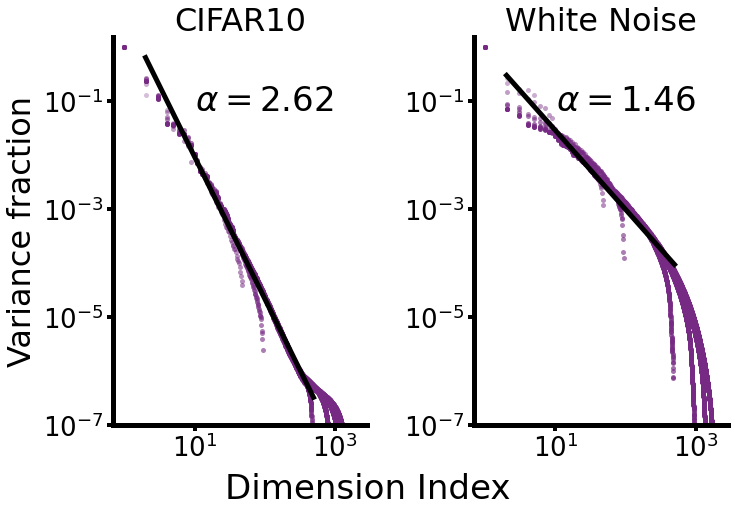

In [151]:
plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

fig, axs = plt.subplots(1, 2)
for i, (cifar_spectrum, gauss_spectrum) in enumerate(zip(kh_spectra_cifar, kh_spectra_gauss)):
    cs = cifar_spectrum.copy()
    gs = gauss_spectrum.copy()
    
    # renormalize the x range
    n = np.arange(1, len(gs) + 1)
    #n = np.divide(n, float(n[-1]))
    
    # renormalize the spectral data
    cs /= cs[0]
    gs /= gs[0]
    
    alpha = well_balanced_alpha_gradient(i, len(kh_spectra_gauss))
    axs[0].loglog(n, cs, ".", color=cmap["kh"], alpha=alpha)
    axs[1].loglog(n, gs, ".", color=cmap["kh"], alpha=alpha)

axs[0].loglog(selected_n, l_n(selected_n, slope_cifar, intercept_cifar), "-", color='#000000')
axs[1].loglog(selected_n, l_n(selected_n, slope_gauss, intercept_gauss), "-", color='#000000')
#ax.loglog(n, l_n_trained_gauss)
#fig.title(r"")
fig.text(0.5, 0.06, "Dimension Index", ha='center')
axs[0].set_ylabel("Variance fraction")
axs[0].set_title("CIFAR10")
axs[1].set_title("White Noise")
axs[0].set_ylim([1e-7, 1.5])
axs[1].set_ylim([1e-7, 1.5])
axs[0].set_xlabel("dummy", color="#ffffff")
axs[1].set_xlabel("dummy", color="#ffffff")
axs[0].text(100., 1e-1, 
            r"$\alpha = " + f"{-slope_cifar:.2f}" + r"$", 
            #r"$\alpha = " + f"{slope_cifar:.2f}" + r"\pm" f"{std_err_cifar:.2f}" + r"$", 
            horizontalalignment='center',
            verticalalignment='center',
            #transform=ax.transAxes,
           )
axs[1].text(100., 1e-1, 
            r"$\alpha = " + f"{-slope_gauss:.2f}" + r"$",
            #r"$\alpha = " + f"{slope_gauss:.2f}" + r"\pm" f"{std_err_gauss:.2f}" + r"$", 
            horizontalalignment='center',
            verticalalignment='center',
            #transform=ax.transAxes,
           )
fig.tight_layout()
fig.savefig(figure_path / Path("ValidatePowerLaw.pdf"))


# Spectral Comparison Plot

In [18]:
from torch.utils.data import DataLoader

def cov_spectrum(
    dataloader: DataLoader,
    model: LocalLearning.HiddenLayerModel,
    device: torch.device,
    dtype: torch.dtype=torch.float32,
) -> torch.Tensor:
    with torch.no_grad():
        noE = model.pSet["hidden_size"]
        
        auto_corr = torch.zeros((noE, noE), device=device, dtype=dtype)
        mean = torch.zeros((noE, ), device=device, dtype=dtype)
        pop_size = 0
        
        f, _ = next(iter(dataloader))
        K = f.mean()
        
        with tqdm(dataloader, unit="batch") as ttest:
            ttest.set_description(f"Calculating covariance spectrum")
            for x, _ in ttest:
                pop_size += len(x)
                hidden_rep = model.hidden(x.to(device))
                data = hidden_rep - K
                auto_corr += data.T @ data
                mean += data.sum(axis=0)
                
        cov = auto_corr - mean[None].T @ mean[None] / pop_size
        cov /= pop_size - 1
        
        l_real = torch.linalg.eigvals(cov).real
        l_n, _ = torch.sort(l_real, descending=True)
        
        return l_n

In [19]:
bp_cifar_spectrum = cov_spectrum(dataloader_test, bpmodel, device)
bp_gauss_spectrum = cov_spectrum(dataloader_gauss, bpmodel, device)

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

In [20]:
# initialised model
khlayer_init = LocalLearning.FKHL3(khlayer.pSet, sigma=1.0)
khlayer_init.to(device)
khlayer_init.eval()

# identity model for testing against the dataset itself
IDmodel = LocalLearning.IdentityModel(khlayer.pSet)
IDmodel.to(device)
IDmodel.eval()

init_cifar_spectrum = LocalLearning.cov_spectrum(dataloader_test, khlayer_init, device)
init_gauss_spectrum = LocalLearning.cov_spectrum(dataloader_gauss, khlayer_init, device)
ID_cifar_spectrum = LocalLearning.cov_spectrum(dataloader_test, IDmodel, device)
ID_gauss_spectrum = LocalLearning.cov_spectrum(dataloader_gauss, IDmodel, device)

Calculating covariance spectrum: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.23batch/s]


In [24]:
kh_cifar_spectrum_cpu = kh_spectra_cifar[-1]
kh_gauss_spectrum_cpu = kh_spectra_gauss[-1]
bp_cifar_spectrum_cpu = bp_cifar_spectrum.detach().cpu().numpy().copy()
bp_gauss_spectrum_cpu = bp_gauss_spectrum.detach().cpu().numpy().copy()
init_cifar_spectrum_cpu = init_cifar_spectrum.detach().cpu().numpy().copy()
init_gauss_spectrum_cpu = init_gauss_spectrum.detach().cpu().numpy().copy()
ID_cifar_spectrum_cpu = ID_cifar_spectrum.detach().cpu().numpy().copy()
ID_gauss_spectrum_cpu = ID_gauss_spectrum.detach().cpu().numpy().copy()

In [56]:
# fit linear models to the power law part of the spectrum

min_win = 1
max_win = 500

noD = len(kh_cifar_spectrum_cpu) + 1
n = np.arange(1, noD)
selected_n = n.copy()[min_win: max_win]
selected_kh_cifar_spectrum = kh_cifar_spectrum_cpu.copy()
selected_kh_cifar_spectrum = (selected_kh_cifar_spectrum / selected_kh_cifar_spectrum[0])[min_win: max_win]
selected_kh_gauss_spectrum = kh_gauss_spectrum_cpu.copy()
selected_kh_gauss_spectrum = (selected_kh_gauss_spectrum / selected_kh_gauss_spectrum[0])[min_win: max_win]
selected_bp_cifar_spectrum = bp_cifar_spectrum_cpu.copy()
selected_bp_cifar_spectrum = (selected_bp_cifar_spectrum / selected_bp_cifar_spectrum[0])[min_win: max_win]
selected_bp_gauss_spectrum = bp_gauss_spectrum_cpu.copy()
selected_bp_gauss_spectrum = (selected_bp_gauss_spectrum / selected_bp_gauss_spectrum[0])[min_win: max_win]
selected_init_cifar_spectrum = init_cifar_spectrum_cpu.copy()
selected_init_cifar_spectrum = (selected_init_cifar_spectrum / selected_init_cifar_spectrum[0])[min_win: max_win]
selected_init_gauss_spectrum = init_gauss_spectrum_cpu.copy()
selected_init_gauss_spectrum = (selected_init_gauss_spectrum / selected_init_gauss_spectrum[0])[min_win: max_win]
selected_ID_cifar_spectrum = ID_cifar_spectrum_cpu.copy()
selected_ID_cifar_spectrum = (selected_ID_cifar_spectrum / selected_ID_cifar_spectrum[0])[min_win: max_win]
selected_ID_gauss_spectrum = ID_gauss_spectrum_cpu.copy()
selected_ID_gauss_spectrum = (selected_ID_gauss_spectrum / selected_ID_gauss_spectrum[0])[min_win: max_win]



slope_kh_cifar, intercept_kh_cifar, r_kh_cifar, p_kh_cifar, std_err_kh_cifar = \
    stats.linregress(np.log(selected_n), np.log(selected_kh_cifar_spectrum))

slope_kh_gauss, intercept_kh_gauss, r_kh_gauss, p_kh_gauss, std_err_kh_gauss = \
    stats.linregress(np.log(selected_n), np.log(selected_kh_gauss_spectrum))

slope_bp_cifar, intercept_bp_cifar, r_bp_cifar, p_bp_cifar, std_err_bp_cifar = \
    stats.linregress(np.log(selected_n), np.log(selected_bp_cifar_spectrum))

slope_bp_gauss, intercept_bp_gauss, r_bp_gauss, p_bp_gauss, std_err_bp_gauss = \
    stats.linregress(np.log(selected_n), np.log(selected_bp_gauss_spectrum))

slope_init_cifar, intercept_init_cifar, r_init_cifar, p_init_cifar, std_err_init_cifar = \
    stats.linregress(np.log(selected_n), np.log(selected_init_cifar_spectrum))

slope_init_gauss, intercept_init_gauss, r_init_gauss, p_init_gauss, std_err_init_gauss = \
    stats.linregress(np.log(selected_n), np.log(selected_init_gauss_spectrum))

slope_ID_cifar, intercept_ID_cifar, r_ID_cifar, p_ID_cifar, std_err_ID_cifar = \
    stats.linregress(np.log(selected_n), np.log(selected_ID_cifar_spectrum))

slope_ID_gauss, intercept_ID_gauss, r_ID_gauss, p_ID_gauss, std_err_ID_gauss = \
    stats.linregress(np.log(selected_n), np.log(selected_ID_gauss_spectrum))

print(f"KHModel:")
print(f"CIFAR10: alpha = {slope_kh_cifar:.2f} +- {std_err_kh_cifar:.2f} | R = {r_kh_cifar:.4f}, p = {p_kh_cifar}")
print(f"xi(t): alpha = {slope_kh_gauss:.2f} +- {std_err_kh_gauss:.2f} | R = {r_kh_gauss:.4f}, p = {p_kh_gauss}")

print(f"BPModel:")
print(f"CIFAR10: alpha = {slope_bp_cifar:.2f} +- {std_err_bp_cifar:.2f} | R = {r_bp_cifar:.4f}, p = {p_bp_cifar}")
print(f"xi(t): alpha = {slope_bp_gauss:.2f} +- {std_err_bp_gauss:.2f} | R = {r_bp_gauss:.4f}, p = {p_bp_gauss}")

print(f"InitModel:")
print(f"CIFAR10: alpha = {slope_init_cifar:.2f} +- {std_err_init_cifar:.2f} | R = {r_init_cifar:.4f}, p = {p_init_cifar}")
print(f"xi(t): alpha = {slope_init_gauss:.2f} +- {std_err_init_gauss:.2f} | R = {r_init_gauss:.4f}, p = {p_init_gauss}")

print(f"Data:")
print(f"CIFAR10: alpha = {slope_ID_cifar:.2f} +- {std_err_ID_cifar:.2f} | R = {r_ID_cifar:.4f}, p = {p_ID_cifar}")
print(f"xi(t): alpha = {slope_ID_gauss:.2f} +- {std_err_ID_gauss:.2f} | R = {r_ID_gauss:.4f}, p = {p_ID_gauss}")

KHModel:
CIFAR10: alpha = -2.62 +- 0.01 | R = -0.9977, p = 0.0
xi(t): alpha = -1.46 +- 0.01 | R = -0.9913, p = 0.0
BPModel:
CIFAR10: alpha = -2.80 +- 0.03 | R = -0.9795, p = 0.0
xi(t): alpha = -1.41 +- 0.02 | R = -0.9518, p = 2.9743807104621983e-257
InitModel:
CIFAR10: alpha = -1.47 +- 0.01 | R = -0.9936, p = 0.0
xi(t): alpha = -0.25 +- 0.00 | R = -0.9197, p = 6.484321436974922e-204
Data:
CIFAR10: alpha = -1.42 +- 0.01 | R = -0.9961, p = 0.0
xi(t): alpha = -0.10 +- 0.00 | R = -0.9246, p = 1.6210090068114583e-210


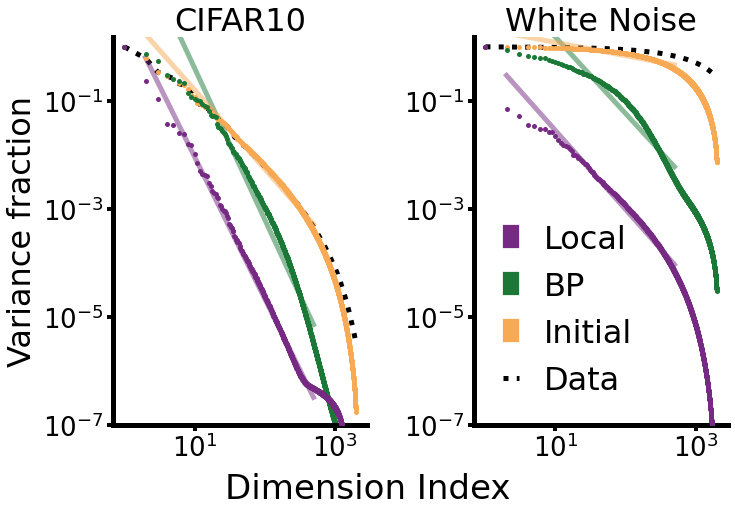

In [149]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

fig, axs = plt.subplots(1, 2)

# renormalize data
kh_cifar_spectrum_cpu /= kh_cifar_spectrum_cpu[0]
kh_gauss_spectrum_cpu /= kh_gauss_spectrum_cpu[0]
bp_cifar_spectrum_cpu /= bp_cifar_spectrum_cpu[0]
bp_gauss_spectrum_cpu /= bp_gauss_spectrum_cpu[0]
init_cifar_spectrum_cpu /= init_cifar_spectrum_cpu[0]
init_gauss_spectrum_cpu /= init_gauss_spectrum_cpu[0]
ID_cifar_spectrum_cpu /= ID_cifar_spectrum_cpu[0]
ID_gauss_spectrum_cpu /= ID_gauss_spectrum_cpu[0]

# plot the data
axs[0].loglog(n, kh_cifar_spectrum_cpu, ".", color=cmap["kh"], zorder=3)
axs[0].loglog(n, bp_cifar_spectrum_cpu, ".", color=cmap["bp"], zorder=2)
axs[0].loglog(n, init_cifar_spectrum_cpu, ".", color=cmap["hybrid"], zorder=1)
axs[0].loglog(n, ID_cifar_spectrum_cpu[:noD-1], color="#000000", linestyle=":", zorder=0)
axs[1].loglog(n, kh_gauss_spectrum_cpu, ".", color=cmap["kh"], zorder=3)
axs[1].loglog(n, bp_gauss_spectrum_cpu, ".", color=cmap["bp"], zorder=2)
axs[1].loglog(n, init_gauss_spectrum_cpu, ".", color=cmap["hybrid"], zorder=1)
axs[1].loglog(n, ID_gauss_spectrum_cpu[:noD-1], color="#000000", linestyle=":", zorder=0)

# plot the fits
axs[0].loglog(selected_n, l_n(selected_n, slope_kh_cifar, intercept_kh_cifar), "-", color=cmap["kh"], alpha=0.5, zorder=0)
axs[0].loglog(selected_n, l_n(selected_n, slope_bp_cifar, intercept_bp_cifar), "-", color=cmap["bp"], alpha=0.5, zorder=0)
axs[0].loglog(selected_n, l_n(selected_n, slope_init_cifar, intercept_init_cifar), "-", color=cmap["hybrid"], alpha=0.5, zorder=0)

axs[1].loglog(selected_n, l_n(selected_n, slope_kh_gauss, intercept_kh_gauss), "-", color=cmap["kh"], alpha=0.5, zorder=0)
axs[1].loglog(selected_n, l_n(selected_n, slope_bp_gauss, intercept_bp_gauss), "-", color=cmap["bp"], alpha=0.5, zorder=0)
axs[1].loglog(selected_n, l_n(selected_n, slope_init_gauss, intercept_init_gauss), "-", color=cmap["hybrid"], alpha=0.5, zorder=0)

#axs[0].loglog(selected_n, l_n(selected_n, slope_cifar, intercept_cifar), "-", color='#000000')
#axs[1].loglog(selected_n, l_n(selected_n, slope_gauss, intercept_gauss), "-", color='#000000')
#ax.loglog(n, l_n_trained_gauss)
#fig.title(r"")
fig.text(0.5, 0.06, "Dimension Index", ha='center')
axs[0].set_ylabel("Variance fraction")
axs[0].set_title("CIFAR10")
axs[1].set_title("White Noise")
axs[0].set_ylim([1e-7, 1.5])
axs[1].set_ylim([1e-7, 1.5])
axs[0].set_xlabel("dummy", color="#ffffff")
axs[1].set_xlabel("dummy", color="#ffffff")


kh_patch = mpatches.Patch(color=cmap["kh"], label="Local")
bp_patch = mpatches.Patch(color=cmap["bp"], label="BP")
init_patch = mpatches.Patch(color=cmap["hybrid"], label="Initial")
data_line = mlines.Line2D([], [], color='black', linestyle=":", label="Data")
axs[1].legend(handles=[kh_patch, bp_patch, init_patch, data_line], handlelength=0.5)

#axs[0].text(100., 1e-1, 
#            r"$\alpha = " + f"{-slope_cifar:.2f}" + r"$", 
#            #r"$\alpha = " + f"{slope_cifar:.2f}" + r"\pm" f"{std_err_cifar:.2f}" + r"$", 
#            horizontalalignment='center',
#            verticalalignment='center',
#            #transform=ax.transAxes,
#           )
#axs[1].text(100., 1e-1, 
#            r"$\alpha = " + f"{-slope_gauss:.2f}" + r"$",
#            #r"$\alpha = " + f"{slope_gauss:.2f}" + r"\pm" f"{std_err_gauss:.2f}" + r"$", 
#            horizontalalignment='center',
#            verticalalignment='center',
#            #transform=ax.transAxes,
#           )
fig.tight_layout()
fig.savefig(figure_path / Path("SpetralComparison.pdf"))

# Adversarial Attack Statistics

In [63]:
# load all the statistics data
with open(model_path / Path("khmodel_attack_statistics_WhiteNoise.pkl"), 'rb') as handle:
    khmodel_WN = pickle.load(handle)
with open(model_path / Path("khmodel_attack_statistics_FGSM.pkl"), 'rb') as handle:
    khmodel_FGSM = pickle.load(handle)
with open(model_path / Path("khmodel_attack_statistics_PGD.pkl"), 'rb') as handle:
    khmodel_PGD = pickle.load(handle)
with open(model_path / Path("bpmodel_attack_statistics_WhiteNoise.pkl"), 'rb') as handle:
    bpmodel_WN = pickle.load(handle)
with open(model_path / Path("bpmodel_attack_statistics_FGSM.pkl"), 'rb') as handle:
    bpmodel_FGSM = pickle.load(handle)
with open(model_path / Path("bpmodel_attack_statistics_PGD.pkl"), 'rb') as handle:
    bpmodel_PGD = pickle.load(handle)

In [83]:
# Attack Statistics
# KH Model
crit = sorted(khmodel_WN["accuracy dict"].keys())[-1]
khmodel_WN_dists = sorted(khmodel_WN["actual accuracy dict"].keys())
idx = bisect.bisect_left(khmodel_WN_dists, crit)
khmodel_WN_dists = khmodel_WN_dists[:idx + 1]
khmodel_WN_acc = [khmodel_WN["actual accuracy dict"][dist] for dist in khmodel_WN_dists]

crit = sorted(khmodel_FGSM["accuracy dict"].keys())[-1]
khmodel_FGSM_dists = sorted(khmodel_FGSM["actual accuracy dict"].keys())
idx = bisect.bisect_left(khmodel_FGSM_dists, crit)
khmodel_FGSM_dists = khmodel_FGSM_dists[:idx + 1]
khmodel_FGSM_acc = [khmodel_FGSM["actual accuracy dict"][dist] for dist in khmodel_FGSM_dists]

crit = sorted(khmodel_PGD["accuracy dict"].keys())[-1]
khmodel_PGD_dists = sorted(khmodel_PGD["actual accuracy dict"].keys())
idx = bisect.bisect_left(khmodel_PGD_dists, crit)
khmodel_PGD_dists = khmodel_PGD_dists[:idx + 1]
khmodel_PGD_acc = [khmodel_PGD["actual accuracy dict"][dist] for dist in khmodel_PGD_dists]

# BP Model
crit = sorted(bpmodel_WN["accuracy dict"].keys())[-1]
bpmodel_WN_dists = sorted(bpmodel_WN["actual accuracy dict"].keys())
idx = bisect.bisect_left(bpmodel_WN_dists, crit)
bpmodel_WN_dists = bpmodel_WN_dists[:idx + 1]
bpmodel_WN_acc = [bpmodel_WN["actual accuracy dict"][dist] for dist in bpmodel_WN_dists]

crit = sorted(bpmodel_FGSM["accuracy dict"].keys())[-1]
bpmodel_FGSM_dists = sorted(bpmodel_FGSM["actual accuracy dict"].keys())
idx = bisect.bisect_left(bpmodel_FGSM_dists, crit)
bpmodel_FGSM_dists = bpmodel_FGSM_dists[:idx + 1]
bpmodel_FGSM_acc = [bpmodel_FGSM["actual accuracy dict"][dist] for dist in bpmodel_FGSM_dists]

crit = sorted(bpmodel_PGD["accuracy dict"].keys())[-1]
bpmodel_PGD_dists = sorted(bpmodel_PGD["actual accuracy dict"].keys())
idx = bisect.bisect_left(bpmodel_PGD_dists, crit)
bpmodel_PGD_dists = bpmodel_PGD_dists[:idx + 1]
bpmodel_PGD_acc = [bpmodel_PGD["actual accuracy dict"][dist] for dist in bpmodel_PGD_dists]

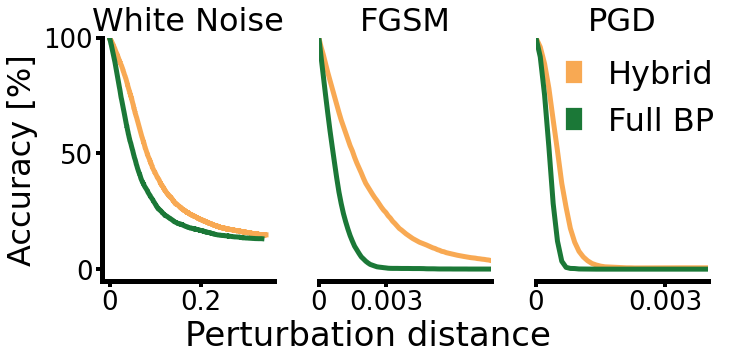

In [160]:
plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

fig, axs = plt.subplots(1, 3)
fig.set_figheight(5.8)
# White Noise
axs[0].set_title("White Noise")
axs[0].plot(khmodel_WN_dists, khmodel_WN_acc, color=cmap["hybrid"])
axs[0].plot(bpmodel_WN_dists, bpmodel_WN_acc, color=cmap["bp"])
axs[0].set_xticks([0.0, 0.2])
axs[0].set_xticklabels(["0", "0.2"])
axs[0].set_xlabel("dummy", color="white")
axs[0].set_ylim([-5.0, 100.0])

# FGSM
axs[1].set_title("FGSM")
axs[1].plot(khmodel_FGSM_dists, khmodel_FGSM_acc, color=cmap["hybrid"])
axs[1].plot(bpmodel_FGSM_dists, bpmodel_FGSM_acc, color=cmap["bp"])
axs[1].set_yticks([])
axs[1].spines["left"].set_visible(False)
axs[1].set_xlim([0.0, bpmodel_FGSM_dists[-1]])
axs[1].set_ylim([-5.0, 100.0])
axs[1].set_xticks([0.0, 0.003])
axs[1].set_xticklabels(["0", "0.003"])
axs[1].set_xlabel("dummy", color="white")

# bp model
axs[2].set_title("PGD")
axs[2].plot(khmodel_PGD_dists, khmodel_PGD_acc, color=cmap["hybrid"])
axs[2].plot(bpmodel_PGD_dists, bpmodel_PGD_acc, color=cmap["bp"])
axs[2].set_yticks([])
axs[2].spines["left"].set_visible(False)
axs[2].set_xlim([0.0, 0.004])
axs[2].set_xticks([0.0, 0.003])
axs[2].set_xticklabels(["0", "0.003"])
axs[2].set_xlabel("dummy", color="white")
axs[2].set_ylim([-5.0, 100.0])

axs[0].set_ylabel("Accuracy [%]")

# legend
kh_patch = mpatches.Patch(color=cmap["hybrid"], label="Hybrid")
bp_patch = mpatches.Patch(color=cmap["bp"], label="Full BP")
axs[2].legend(
    handles=[kh_patch, bp_patch], 
    handlelength=0.5,
    loc="center right", 
    bbox_to_anchor=(1.2, 0.75),
)

fig.text(0.5, 0.1, "Perturbation distance", ha='center')
fig.tight_layout()
fig.savefig(figure_path / Path("AttackAccuracy.pdf"))

In [162]:
khmodel_crit_eps_WN = khmodel_WN["critical epsilon"]
khmodel_crit_eps_WN = khmodel_crit_eps_WN[~np.isnan(khmodel_crit_eps_WN)]

khmodel_crit_eps_FGSM = khmodel_FGSM["critical epsilon"]
khmodel_crit_eps_FGSM = khmodel_crit_eps_FGSM[~np.isnan(khmodel_crit_eps_FGSM)]

khmodel_crit_eps_PGD = khmodel_PGD["critical epsilon"]
khmodel_crit_eps_PGD = khmodel_crit_eps_PGD[~np.isnan(khmodel_crit_eps_PGD)]

bpmodel_crit_eps_WN = bpmodel_WN["critical epsilon"]
bpmodel_crit_eps_WN = bpmodel_crit_eps_WN[~np.isnan(bpmodel_crit_eps_WN)]

bpmodel_crit_eps_FGSM = bpmodel_FGSM["critical epsilon"]
bpmodel_crit_eps_FGSM = bpmodel_crit_eps_FGSM[~np.isnan(bpmodel_crit_eps_FGSM)]

bpmodel_crit_eps_PGD = bpmodel_PGD["critical epsilon"]
bpmodel_crit_eps_PGD = bpmodel_crit_eps_PGD[~np.isnan(bpmodel_crit_eps_PGD)]

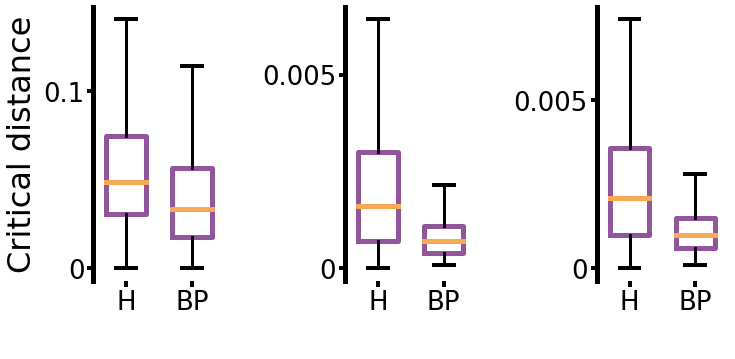

In [194]:
plt.style.use(['seaborn-paper', "./A1PosterPortrait.mplstyle"])

# box plot customisations
boxprops = dict(linestyle='-', linewidth=5.0, color=cmap["kh"], alpha=0.8)
medianprops = dict(linestyle='-', linewidth=5.0, color=cmap["hybrid"])
whiskerprops = dict(linewidth=3.0)
capprops = dict(linewidth=4.0)
#meanpointprops = dict(marker='D', markeredgecolor='black',
#                      markerfacecolor='firebrick')
#meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')


fig, axs = plt.subplots(1, 3)
fig.set_figheight(5.8)
# White Noise
#axs[0].set_title("White Noise")
axs[0].boxplot(
    (khmodel_crit_eps_WN, bpmodel_crit_eps_WN),
    widths=0.6,
    showfliers=False,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
)
axs[0].set_xticklabels(['H', 'BP'])
axs[0].set_xlabel("dummy", color="white")
axs[0].spines["bottom"].set_visible(False)
axs[0].set_yticks([0.0, 0.1])
axs[0].set_yticklabels(["0", "0.1"])
#axs[0].set_ylim([-5.0, 100.0])

# FGSM
#axs[1].set_title("FGSM")
axs[1].boxplot(
    (khmodel_crit_eps_FGSM, bpmodel_crit_eps_FGSM),
    widths=0.6,
    showfliers=False,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
)
axs[1].set_xticklabels(['H', 'BP'])
axs[1].set_xlabel("dummy", color="white")
axs[1].spines["bottom"].set_visible(False)
axs[1].set_yticks([0.0, 0.005])
axs[1].set_yticklabels(["0", "0.005"])
#axs[1].set_ylim([-5.0, 100.0])

# bp model
#axs[2].set_title("PGD")
axs[2].boxplot(
    (khmodel_crit_eps_PGD, bpmodel_crit_eps_PGD),
    widths=0.6,
    showfliers=False,
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
)
axs[2].set_xticklabels(['H', 'BP'])
axs[2].set_xlabel("dummy", color="white")
axs[2].spines["bottom"].set_visible(False)
axs[2].set_yticks([0.0, 0.005])
axs[2].set_yticklabels(["0", "0.005"])
#axs[2].set_ylim([-5.0, 100.0])

axs[0].set_ylabel("Critical distance")

# legend
#kh_patch = mpatches.Patch(color=cmap["hybrid"], label="Hybrid")
#bp_patch = mpatches.Patch(color=cmap["bp"], label="Full BP")
#axs[2].legend(
#    handles=[kh_patch, bp_patch], 
#    handlelength=0.5,
#    loc="center right", 
#    bbox_to_anchor=(1.2, 0.75),
#)

#fig.text(0.5, 0.1, "Perturbation distance", ha='center')
fig.tight_layout()
fig.savefig(figure_path / Path("AttackCriticalDistance.pdf"))